# Project Overview: Movie Recommendation System Using Singular Value Decomposition (SVD)

#### Problem Statement

* The task is to build a movie recommendation system that predicts how likely a user will rate a particular movie based on their previous ratings. We will be using a combination of Singular Value Decomposition (SVD) and collaborative filtering techniques to predict missing ratings in a user-item matrix. The ultimate goal is to recommend movies to users that they might like but have not yet rated.

#### Approach

* Data Loading: The ratings data is loaded into a pandas DataFrame, and a user-item interaction matrix is constructed, with users as rows, movies as columns, and ratings as the values in the matrix.

* Handling Missing Data: Missing ratings (NaN values) in the matrix are the key to building the recommendation system. SVD will be used to fill these missing ratings based on existing user-item interactions.

* Applying SVD: Singular Value Decomposition is applied to the user-item matrix to factorize it into three matrices (user, singular values, item). These matrices are then used to predict the missing ratings.

* Generating Recommendations: Based on the predicted ratings, a list of recommended movies will be generated for each user. These recommendations will be the movies that the user is most likely to enjoy but has not yet rated.

In [1]:
# setting up libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
dataset=pd.read_csv("combined_data_1.txt",header=None,usecols=[0,1],names=["Cust_Id","Rating"])
dataset.head()

,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


In [5]:
dataset.head() 

,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


* Print the datatype of columns

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24058263 entries, 0 to 24058262
Data columns (total 2 columns):
 #   Column   Dtype  
---  ------   -----  
 0   Cust_Id  object 
 1   Rating   float64
dtypes: float64(1), object(1)
memory usage: 367.1+ MB


* We have Cust_Id in object and Rating in float . We will change Cust_Id dtype column into int further.

In [11]:
dataset.shape

(24058263, 2)

* We have a huge dataset conatining 24058263 rows and 2 columns.

In [14]:
dataset.head()

,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


#### Finding distribution of different Rating.

In [17]:
p=dataset.groupby(["Rating"])["Rating"].agg("count")
p

Rating
1.0    1118186
2.0    2439073
3.0    6904181
4.0    8085741
5.0    5506583
Name: Rating, dtype: int64

* We have more 4 star rated movied in our dataset.

#### Getting movie count by counting nan values.

In [21]:
movie_count=dataset.isnull().sum().iloc[1]
movie_count

4499

#### Getting Customer count

In [24]:
cust_count=dataset["Cust_Id"].nunique()-movie_count
cust_count

470758

* Notes:- There are 4499 movies and 470758 customers in our datset.

#### Getting Rating Count

In [28]:
rating_count=np.sum(dataset.groupby("Rating").size().values)
rating_count

24053764

## To plot the distribution of the ratings in as a bar plot

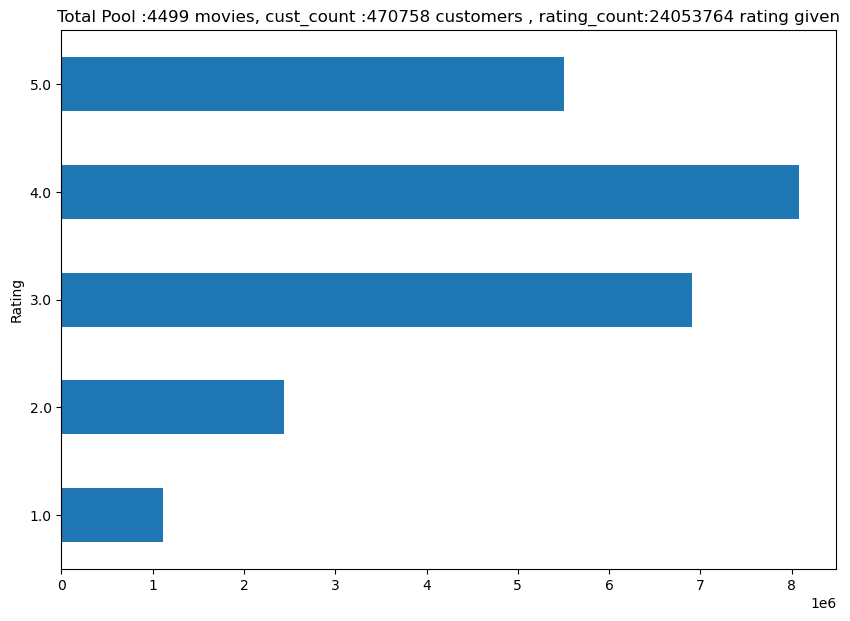

In [31]:
ax=p.plot(kind="barh",figsize=(10,7),legend=False)
plt.title(f"Total Pool :{movie_count} movies, cust_count :{cust_count} customers , rating_count:{rating_count} rating given")
plt.show()

In [33]:
dataset.shape

(24058263, 2)

In [35]:
dataset.head()

,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


* Note:-In the given dataset, Cust_Id contains both movie IDs (e.g., "1:", "2:") and customer IDs with ratings. Each movie ID is followed by multiple customers who have rated that movie.The goal is to assign a "Movie_ID" column to each customer entry so that we can associate every rating with the correct movie.

In [38]:
current_movie_id=None
movie_id=[]
for id in dataset["Cust_Id"]:
    if ":" in id:
        current_movie_id=int(id.replace(":",""))
    movie_id.append(current_movie_id)

dataset["Movie_Id"]=movie_id

In [40]:
dataset.head()

,Cust_Id,Rating,Movie_Id
0,1:,NaN,1
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1


* Note:- Now dropping the NaN values from datset.

In [43]:
dataset.dropna(inplace=True)

In [44]:
dataset.head(2)

,Cust_Id,Rating,Movie_Id
1,1488844,3.0,1
2,822109,5.0,1


In [47]:
dataset.shape

(24053764, 3)

# Data Cleaning 

In [50]:
# count and mean
f=["count","mean"]

In [52]:
dataset_movie_summray=dataset.groupby(["Movie_Id"])["Rating"].agg(f)

In [53]:
dataset_movie_summray

,count,mean
Movie_Id,,
1,547,3.749543
2,145,3.558621
3,2012,3.641153
4,142,2.739437
5,1140,3.919298
...,...,...
4495,614,3.478827
4496,9519,3.763000
4497,714,2.715686


### Creating a list of those movies which are less rated (want to keep only top 30% rated movies)

In [57]:
movie_benchmark=round(dataset_movie_summray["count"].quantile(0.7))
movie_benchmark

1799

In [59]:
drop_movie_list=dataset_movie_summray[dataset_movie_summray["count"]<movie_benchmark].index
drop_movie_list

Index([   1,    2,    4,    5,    6,    7,    9,   10,   11,   12,
       ...
       4484, 4486, 4487, 4489, 4491, 4494, 4495, 4497, 4498, 4499],
      dtype='int64', name='Movie_Id', length=3149)

## Creating a list of those users who is giving less rating (want to keep only top 30% users)

In [62]:
dataset_cust_summray=dataset.groupby(["Cust_Id"])["Rating"].agg(f)
dataset_cust_summray

,count,mean
Cust_Id,,
10,49,3.346939
1000004,1,5.000000
1000027,30,4.300000
1000033,101,3.316832
1000035,20,4.400000
...,...,...
999964,48,4.062500
999972,35,4.057143
999977,14,3.714286


In [63]:
cust_benchmark=dataset_cust_summray["count"].quantile(0.7)
cust_benchmark   

52.0

In [66]:
drop_cust_list=dataset_cust_summray[dataset_cust_summray["count"]<cust_benchmark].index
drop_cust_list 

Index(['10', '1000004', '1000027', '1000035', '1000038', '1000051', '1000057',
       '100006', '100007', '1000072',
       ...
       '999932', '999935', '99994', '999945', '999949', '999964', '999972',
       '999977', '999984', '999988'],
      dtype='object', name='Cust_Id', length=327300)

## Cutting dataset based on these two conditions

In [69]:
print(f"before trimming shape of data {dataset.shape}")

before trimming shape of data (24053764, 3)


In [71]:
dataset=dataset[~dataset["Movie_Id"].isin(drop_movie_list)]
dataset=dataset[~dataset["Cust_Id"].isin(drop_cust_list)]

In [72]:
print(f"after trimming shape of data {dataset.shape}")

after trimming shape of data (17337458, 3)


In [73]:
print("example dataset")
dataset.head()    

example dataset


,Cust_Id,Rating,Movie_Id
696,712664,5.0,3
697,1331154,4.0,3
698,2632461,3.0,3
699,44937,5.0,3
700,656399,4.0,3


## Creating rating matrix

In [78]:
df_p=dataset.pivot_table(index="Cust_Id",columns="Movie_Id",values="Rating")
df_p

Movie_Id,3,8,16,17,18,26,28,30,32,33,...,4472,4474,4478,4479,4485,4488,4490,4492,4493,4496
Cust_Id,,,,,,,,,,,,,,,,,,,,,
1000033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000079,NaN,NaN,NaN,NaN,NaN,NaN,2.0,4.0,NaN,NaN,...,3.0,NaN,NaN,4.0,NaN,2.0,NaN,NaN,NaN,NaN
1000084,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999901,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
999903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
999913,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Loading the movie title dataset

In [133]:
df_title = pd.read_csv('movie_titles.csv', encoding = "unicode_escape", header = None, usecols=[0,1,2],names = ['Movie_Id', 'Year', 'Name'])

df_title.set_index('Movie_Id', inplace = True)

df_title.head(10)                

,Year,Name
Movie_Id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW
6,1997.0,Sick
7,1992.0,8 Man
8,2004.0,What the #$*! Do We Know!?
9,1991.0,Class of Nuke 'Em High 2


#### Importing required libraries

In [83]:
from surprise import Reader,Dataset,SVD
from surprise.model_selection import cross_validate

In [85]:
# load reader libraries
reader=Reader()

# get just top 100K rows for faster run time

data=Dataset.load_from_df(dataset[["Cust_Id","Movie_Id","Rating"]][:100000],reader)

# use the svd model
svd=SVD()

# compute the rmse of the svd algorithm

cross_validate(svd,data,measures=["RMSE","MAE"],cv=3,verbose=True) 

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0014  0.9999  0.9944  0.9986  0.0030  
MAE (testset)     0.7928  0.7883  0.7907  0.7906  0.0018  
Fit time          1.81    1.92    1.80    1.85    0.05    
Test time         0.52    0.45    0.44    0.47    0.03    


{'test_rmse': array([1.00140077, 0.9998953 , 0.99436021]),
 'test_mae': array([0.79278854, 0.78833113, 0.79069132]),
 'fit_time': (1.8117380142211914, 1.9202439785003662, 1.803961992263794),
 'test_time': (0.5160834789276123, 0.45365452766418457, 0.4438591003417969)}

In [87]:
dataset.head()

,Cust_Id,Rating,Movie_Id
696,712664,5.0,3
697,1331154,4.0,3
698,2632461,3.0,3
699,44937,5.0,3
700,656399,4.0,3


In [135]:
dataset.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 17337458 entries, 696 to 24056846
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Cust_Id   int32  
 1   Rating    float64
 2   Movie_Id  int64  
dtypes: float64(1), int32(1), int64(1)
memory usage: 463.0 MB


In [91]:
# changing Cust_id into int
dataset["Cust_Id"]=dataset["Cust_Id"].astype(int)

In [92]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17337458 entries, 696 to 24056846
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Cust_Id   int32  
 1   Rating    float64
 2   Movie_Id  int64  
dtypes: float64(1), int32(1), int64(1)
memory usage: 463.0 MB


### To find all the movies rated as 5 stars by user with userId = 712664

In [137]:
dataset_712664 = dataset[(dataset['Cust_Id'] == 712664) & (dataset['Rating'] == 5)]
dataset_712664 = dataset_712664.set_index('Movie_Id')
dataset_712664 = dataset_712664.join(df_title)['Name']
dataset_712664.head(10)

Movie_Id
3                              Character
79                           The Killing
175                       Reservoir Dogs
199                      The Deer Hunter
241                   North by Northwest
256    Ghost Dog: The Way of the Samurai
348        The Last Temptation of Christ
357                House of Sand and Fog
416                             Elephant
442                  Mississippi Burning
Name: Name, dtype: object

## Predicting Recommended Movies.

In [142]:
user_712664 = df_title.copy()

user_712664 = user_712664.reset_index()

#To remove all the movies rated less often 
user_712664 = user_712664[~user_712664['Movie_Id'].isin(drop_movie_list)]


# getting full dataset
data = Dataset.load_from_df(dataset[['Cust_Id', 'Movie_Id', 'Rating']], reader)

#create a training set for svd
trainset = data.build_full_trainset()
svd.fit(trainset)

#Predict the ratings for user_712664
user_712664['Estimate_Score'] = user_712664['Movie_Id'].apply(lambda x: svd.predict(712664, x).est)

#Drop extra columns from the user_712664 data frame
user_712664 = user_712664.drop('Movie_Id', axis = 1)

# Sort predicted ratings for user_712664 in descending order
user_712664 = user_712664.sort_values('Estimate_Score', ascending=False)

#Print top 10 recommendations
print(user_712664.head(10)) 

        Year                            Name  Estimate_Score
174   1992.0                  Reservoir Dogs        5.000000
4352  2002.0  Curb Your Enthusiasm: Season 3        5.000000
470   1931.0                     City Lights        5.000000
871   1954.0                   Seven Samurai        5.000000
3289  1974.0                   The Godfather        5.000000
721   2003.0              The Wire: Season 1        5.000000
1740  1999.0              Cowboy Bebop Remix        5.000000
2101  1994.0          The Simpsons: Season 6        5.000000
560   1963.0                    High and Low        4.998198
995   1961.0                         Yojimbo        4.968216


# Conclusion

* Data Preprocessing: The dataset was cleaned by removing movies rated less frequently, which helps ensure that the recommendations are based on popular, well-rated movies, improving model relevance.

* Collaborative Filtering with SVD: Singular Value Decomposition (SVD) was used for collaborative filtering, which is effective for capturing hidden relationships between users and movies, providing personalized recommendations.

* Model Training: The SVD model was trained on the full dataset, which helps the model learn latent factors and patterns in user preferences and movie characteristics.

* Rating Prediction: The model predicted ratings for the user, offering personalized suggestions based on their movie preferences, even for movies they haven't rated yet.

* Recommendation Sorting: The predicted ratings were sorted in descending order, ensuring the top 10 movie recommendations are those the model believes the user would most likely enjoy based on their previous ratings.

* User-Centric Output: The final output is a personalized list of movie recommendations for user_712664, which can be used to improve their experience and guide their movie choices.

* Model Can predict movies for other user as well.